In [1]:
import tarfile
import matplotlib.pyplot as plt
import matplotlib  #ajustar
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import backend as K
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import OneHotEncoder
import idx2numpy
import csv

import import_ipynb
from utils import *
from autoencoder_and_clustering_models import *

importing Jupyter notebook from utils.ipynb
importing Jupyter notebook from autoencoder_and_clustering_models.ipynb


# Function to read MNIST Dataset

<br/>
Download [MNIST](http://yann.lecun.com/exdb/mnist/), save it in 'arq_path' and unzip it. <br/>
This function also normalizes the images between 0 and 1.<br/>

In [2]:
def read_preprocess_dataset(arq_path, indexes_train, indexes_val = np.empty(0)):
    
    # indexes_train = indexes of images that will be used during training
    # indexes_val = indexes of images that will be used for validation

    file = arq_path + '\\train-images-idx3-ubyte\\train-images.idx3-ubyte'
    img_train_val = idx2numpy.convert_from_file(file)

    file = arq_path + '\\t10k-images-idx3-ubyte\\t10k-images.idx3-ubyte'
    img_test = idx2numpy.convert_from_file(file)

    file = arq_path + '\\train-labels-idx1-ubyte\\train-labels.idx1-ubyte'
    target_train_val = idx2numpy.convert_from_file(file)

    file = arq_path + '\\t10k-labels-idx1-ubyte\\t10k-labels.idx1-ubyte'
    target_test = idx2numpy.convert_from_file(file)
    
    
    indexes_train = indexes_train.astype(int)
    indexes_val = indexes_val.astype(int)
    
    data_train_val = np.expand_dims(img_train_val, axis=3)
    data_test = np.expand_dims(img_test, axis=3)

    data_train_val = data_train_val/255
    data_test = data_test/255
    
    
    if indexes_val.size==0:
        data_train = data_train_val
        target_train = target_train_val
        
        return data_train, data_test, target_train, target_test
    
    else:
        data_train = data_train_val[indexes_train]
        target_train = target_train_val[indexes_train]
        
        data_val = data_train_val[indexes_val]
        target_val = target_train_val[indexes_val]
        
        return data_train, data_val, data_test, target_train, target_val, target_test
    
    

# Summary of the structure of the encoder that will be used

In [3]:
arq_path = 'D:\Luiza\OneDrive\Documentos\Doutorado\MeusProjetos\deep_clustering\mnist'
model, model_encoder = deep_clustering_model(arq_path + '\Encoder_model_1.h5' , input_shape = (28,28,1))

model_encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_0 (Conv2D)              (None, 28, 28, 32)        1600      
_________________________________________________________________
AC_0 (Activation)            (None, 28, 28, 32)        0         
_________________________________________________________________
BN_0 (BatchNormalization)    (None, 28, 28, 32)        128       
_________________________________________________________________
max_pool_0 (MaxPooling2D)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 14, 14, 16)        12816     
_________________________________________________________________
AC_1 (Activation)            (None, 14, 14, 16)        0         
_________________________________________________________________
BN_1 (BatchNormalization)    (None, 14, 14, 16)        6

<br/><br/>
# Clustering the MNIST Dataset Using Flattened Images

<br/><br/>
For a first test, the MNIST dataset is clustered using the flattened images as inputs to k-means algorithm. <br/>
For a fair comparison with the others trained models, the test dataset is used after training.<br/>

In [4]:
with open(arq_path+"\crossValidation_indexes.csv", newline='') as f:
    list_indexes = csv.reader(f)
    list_indexes = list(list(rec) for rec in csv.reader(f, delimiter=','))
list_indexes = (np.array(list_indexes)).astype(int)


i_crossVal = 0
i_train = np.array([w for w in range(5) if not w == i_crossVal])
indexes_val = list_indexes[i_crossVal]
indexes_train = np.empty(0)
for i in range(len(i_train)):
    indexes_train = np.concatenate ((indexes_train, list_indexes[i_train[i]]), axis=0 )
indexes_val = np.array(indexes_val)
indexes_train = np.array(indexes_train)

data_train, data_val, data_test, label_train, label_val, label_test = read_preprocess_dataset(arq_path, indexes_train, indexes_val ) 

n_clusters = 10

kmeans = KMeans(n_clusters = n_clusters,max_iter=300, n_init=10,algorithm='full', verbose=1)
kmeans.fit(data_train.reshape((len(data_train),-1)))  # Train K-Means.
y_pred_kmeans = kmeans.predict(data_test.reshape((len(data_test),-1)))  



Initialization complete
Iteration  0, inertia 3120534.536
Iteration  1, inertia 2003881.347
Iteration  2, inertia 1948147.093
Iteration  3, inertia 1930741.101
Iteration  4, inertia 1924310.752
Iteration  5, inertia 1919453.648
Iteration  6, inertia 1914783.226
Iteration  7, inertia 1910233.433
Iteration  8, inertia 1906057.844
Iteration  9, inertia 1903032.672
Iteration 10, inertia 1901123.686
Iteration 11, inertia 1899744.373
Iteration 12, inertia 1898790.732
Iteration 13, inertia 1897977.533
Iteration 14, inertia 1897313.977
Iteration 15, inertia 1896785.544
Iteration 16, inertia 1896345.906
Iteration 17, inertia 1896016.235
Iteration 18, inertia 1895743.923
Iteration 19, inertia 1895554.248
Iteration 20, inertia 1895406.040
Iteration 21, inertia 1895265.469
Iteration 22, inertia 1895144.429
Iteration 23, inertia 1895042.310
Iteration 24, inertia 1894965.057
Iteration 25, inertia 1894894.744
Iteration 26, inertia 1894838.300
Iteration 27, inertia 1894776.967
Iteration 28, inertia 18

Iteration 53, inertia 1891672.222
Iteration 54, inertia 1891670.516
Iteration 55, inertia 1891668.659
Iteration 56, inertia 1891665.905
Iteration 57, inertia 1891660.295
Iteration 58, inertia 1891654.569
Iteration 59, inertia 1891650.452
Iteration 60, inertia 1891647.075
Iteration 61, inertia 1891643.164
Iteration 62, inertia 1891639.392
Iteration 63, inertia 1891636.849
Iteration 64, inertia 1891635.534
Iteration 65, inertia 1891634.675
Iteration 66, inertia 1891633.939
Iteration 67, inertia 1891632.851
Iteration 68, inertia 1891631.820
Iteration 69, inertia 1891630.911
Iteration 70, inertia 1891629.974
Iteration 71, inertia 1891629.137
Iteration 72, inertia 1891628.536
Iteration 73, inertia 1891627.958
Iteration 74, inertia 1891627.381
Iteration 75, inertia 1891626.541
Iteration 76, inertia 1891625.992
Iteration 77, inertia 1891625.444
Iteration 78, inertia 1891625.051
Iteration 79, inertia 1891624.650
Iteration 80, inertia 1891624.109
Iteration 81, inertia 1891623.850
Iteration 82, 

Iteration 51, inertia 1888406.564
Iteration 52, inertia 1888331.219
Iteration 53, inertia 1888262.625
Iteration 54, inertia 1888173.988
Iteration 55, inertia 1888075.658
Iteration 56, inertia 1887970.395
Iteration 57, inertia 1887869.591
Iteration 58, inertia 1887781.465
Iteration 59, inertia 1887705.784
Iteration 60, inertia 1887637.101
Iteration 61, inertia 1887566.804
Iteration 62, inertia 1887501.309
Iteration 63, inertia 1887433.918
Iteration 64, inertia 1887358.824
Iteration 65, inertia 1887270.155
Iteration 66, inertia 1887152.856
Iteration 67, inertia 1886998.009
Iteration 68, inertia 1886813.806
Iteration 69, inertia 1886580.844
Iteration 70, inertia 1886278.410
Iteration 71, inertia 1885920.208
Iteration 72, inertia 1885556.591
Iteration 73, inertia 1885150.901
Iteration 74, inertia 1884774.822
Iteration 75, inertia 1884387.046
Iteration 76, inertia 1884038.263
Iteration 77, inertia 1883705.570
Iteration 78, inertia 1883364.847
Iteration 79, inertia 1883038.607
Iteration 80, 

Iteration 35, inertia 1887966.959
Iteration 36, inertia 1887966.781
Iteration 37, inertia 1887966.705
Iteration 38, inertia 1887966.617
Iteration 39, inertia 1887966.454
Iteration 40, inertia 1887966.200
Iteration 41, inertia 1887966.037
Iteration 42, inertia 1887965.842
Iteration 43, inertia 1887965.769
Converged at iteration 43: center shift 6.678344e-06 within tolerance 6.723083e-06
Initialization complete
Iteration  0, inertia 3131501.341
Iteration  1, inertia 1974707.271
Iteration  2, inertia 1933784.639
Iteration  3, inertia 1917795.000
Iteration  4, inertia 1909301.091
Iteration  5, inertia 1903998.330
Iteration  6, inertia 1900625.812
Iteration  7, inertia 1898297.514
Iteration  8, inertia 1896575.855
Iteration  9, inertia 1895222.958
Iteration 10, inertia 1894357.616
Iteration 11, inertia 1893744.398
Iteration 12, inertia 1893324.453
Iteration 13, inertia 1893046.231
Iteration 14, inertia 1892807.729
Iteration 15, inertia 1892584.217
Iteration 16, inertia 1892417.490
Iteration

Confusion Matrix Based on the known Classes


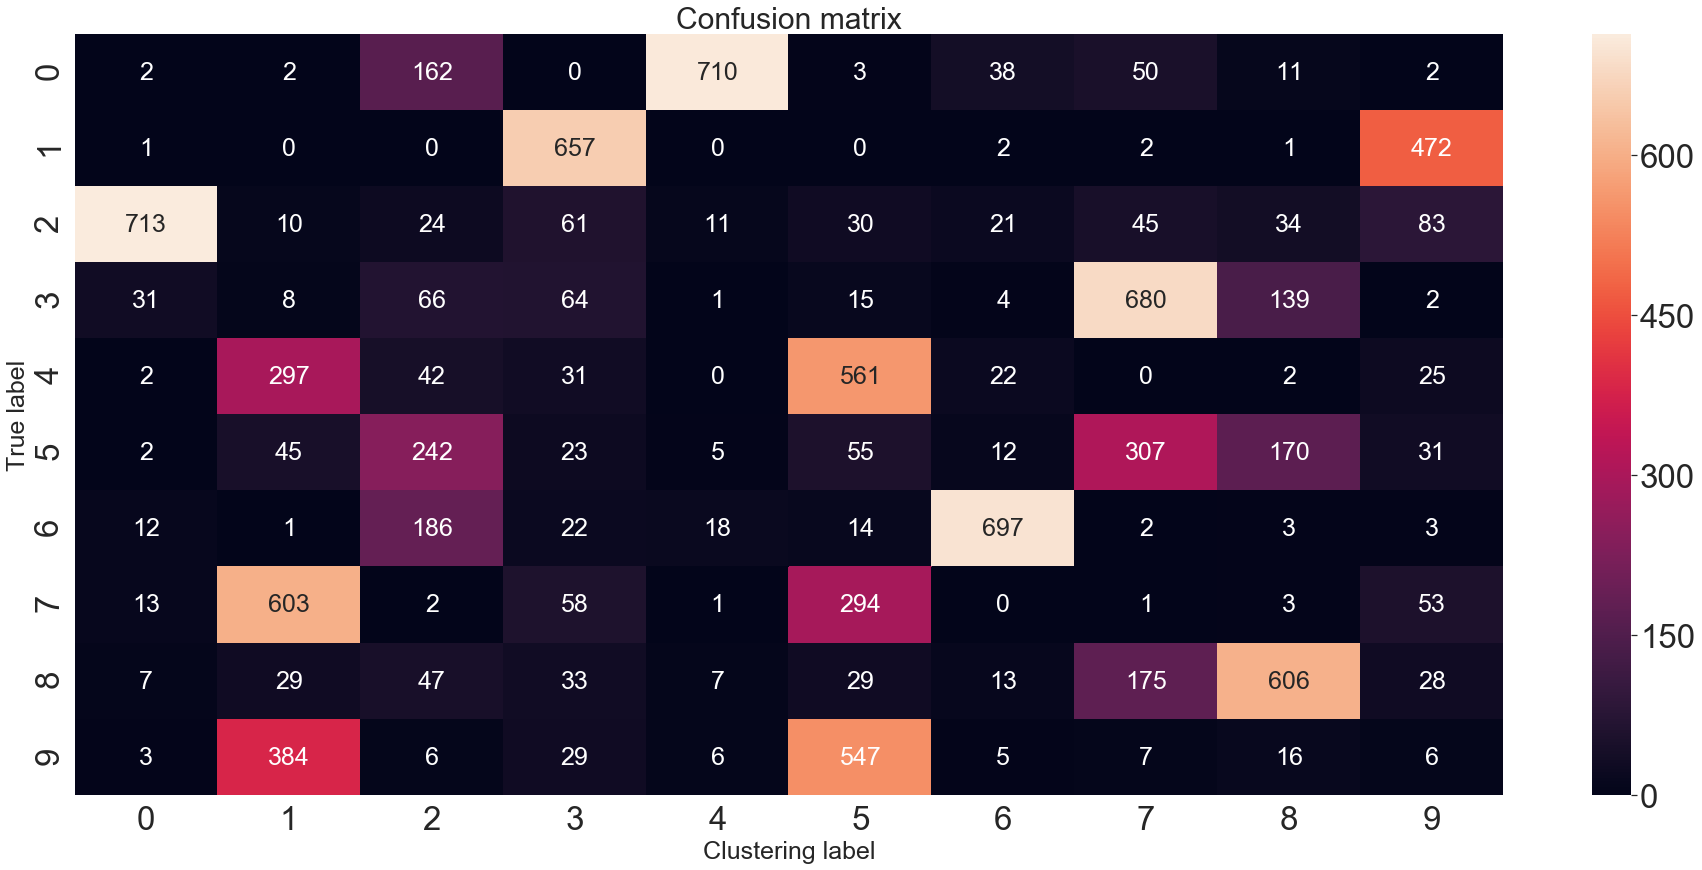

Silhouette of Each Sample per Cluster:


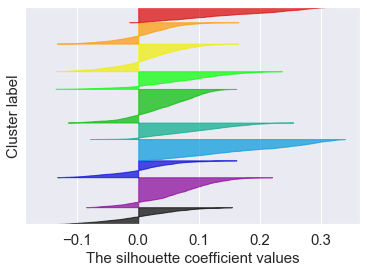


The accuracy for the test dataset, based on previous known classes is:  59.41000 %

The silhouette of the clusterization for the test dateset is:  0.06159


In [7]:
arq_path = 'D:\Luiza\OneDrive\Documentos\Doutorado\MeusProjetos\deep_clustering\mnist'

print('Confusion Matrix Based on the known Classes')

n_classes = 10
confusion_matrix=confusion_matrix_fn(y_pred_kmeans,np.squeeze(label_test), n_classes = n_classes, n_clusters = n_clusters )
plot_cm(confusion_matrix, arq = arq_path+'\confusionMatrix_originalImage.jpg')
acc,err = accuracy(n_clusters, confusion_matrix)

print('Silhouette of Each Sample per Cluster:')

silhouette_avg = silhouette_score(data_test.reshape((len(data_test),-1)), np.squeeze(y_pred_kmeans),metric='euclidean')
sample_silhouette_values = silhouette_samples(data_test.reshape((len(data_test),-1)), np.squeeze(y_pred_kmeans),metric='euclidean')
silhouette_plot(np.squeeze(y_pred_kmeans),silhouette_avg, sample_silhouette_values, n_clusters, arq = arq_path+'\silhouette_originalImage.jpg')
plt.show()

print ('\nThe accuracy for the test dataset, based on previous known classes is:  %.5f' % (acc*100), '%')
print('\nThe silhouette of the clusterization for the test dateset is:  %.5f' % silhouette_avg)

<br/><br/>
# Clustering the MNIST Dataset Using the Encoder Outputs

<br/><br/>
As a second test, the MNIST dataset will be clustered by encoding the images and clustering the encoded outputs with k-means.<br/>
As the autoenconders were trained using 5-folds cross-validation, the five resulted encoders will be used here. <br/>
Each one of the five clustering models trained with the respective encoders outputs will be tested with the same test dataset .<br/>


 
 
	 	 	 Results Validated with Batch  0  Dataset



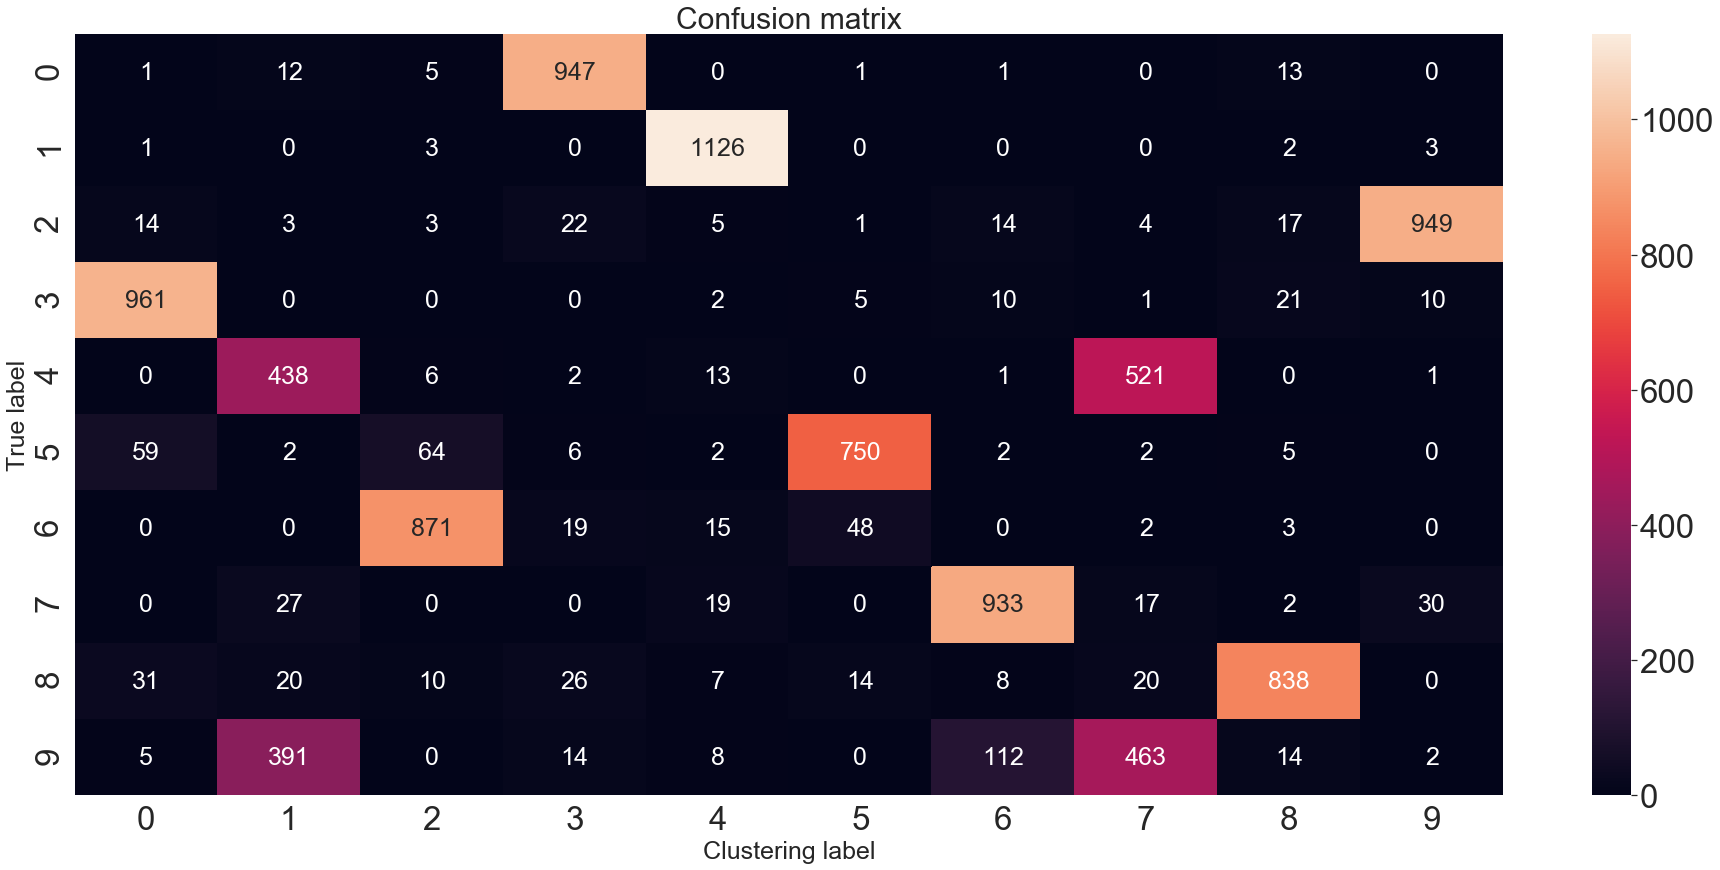

Accuracy =  83.34 % - Error =  16.66 %




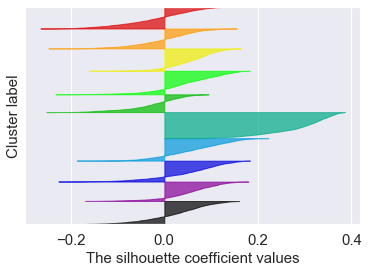


 
 
	 	 	 Results Validated with Batch  1  Dataset



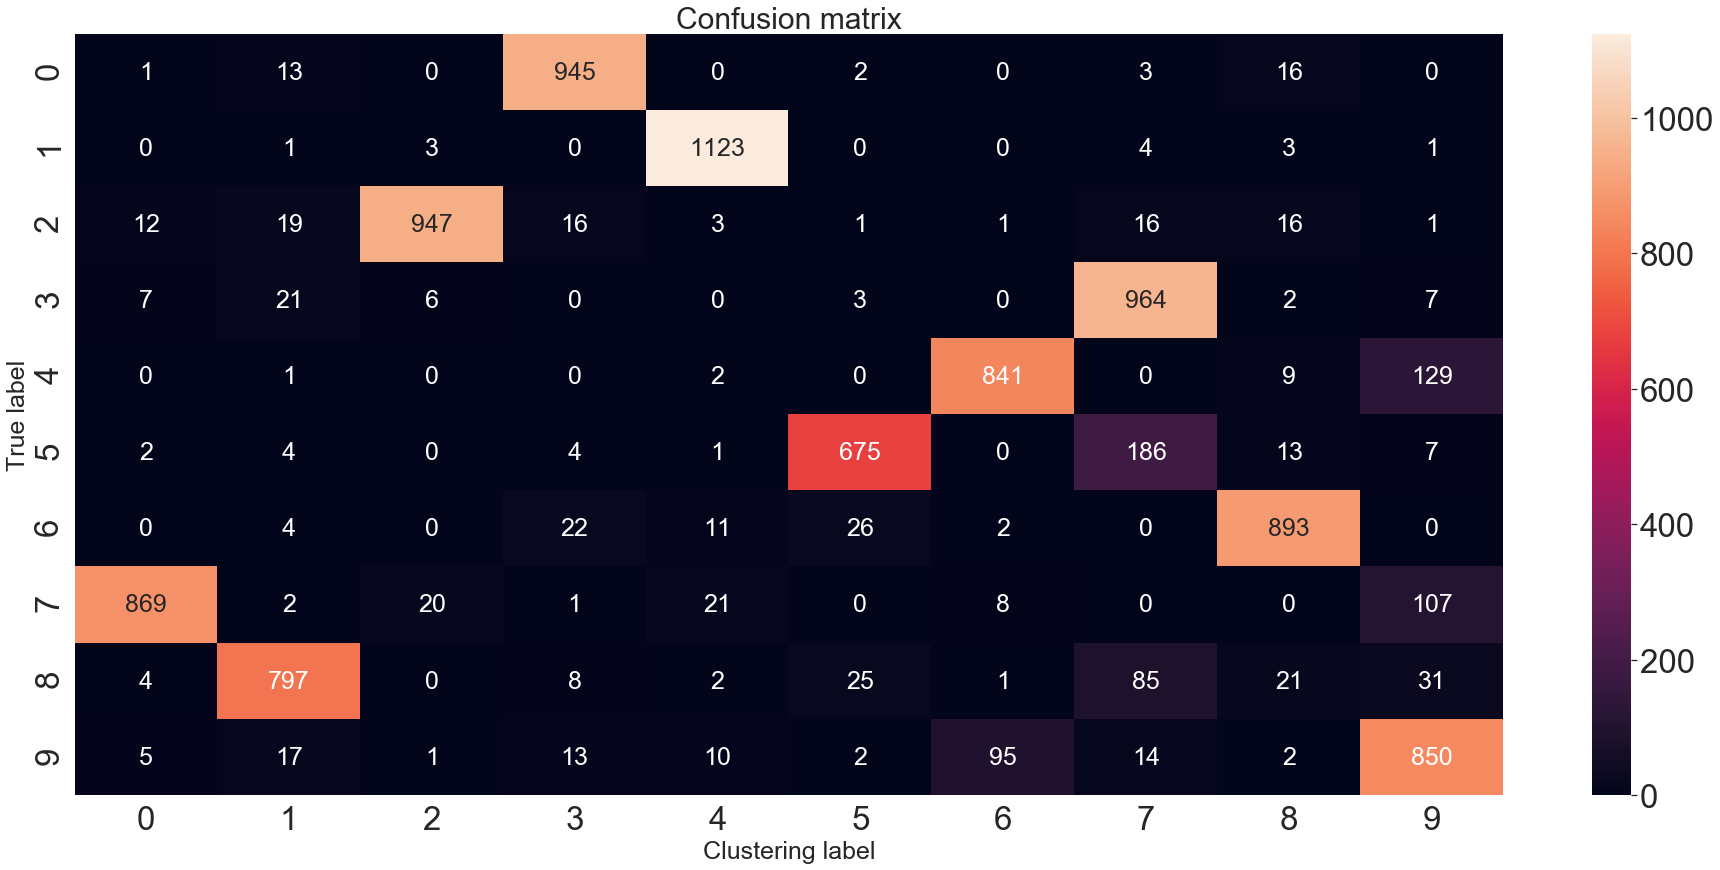

Accuracy =  89.03999999999999 % - Error =  10.96 %




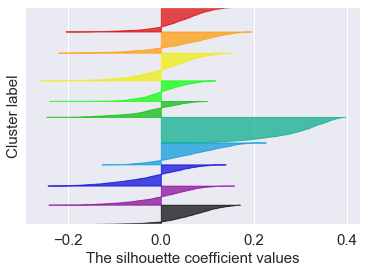


 
 
	 	 	 Results Validated with Batch  2  Dataset



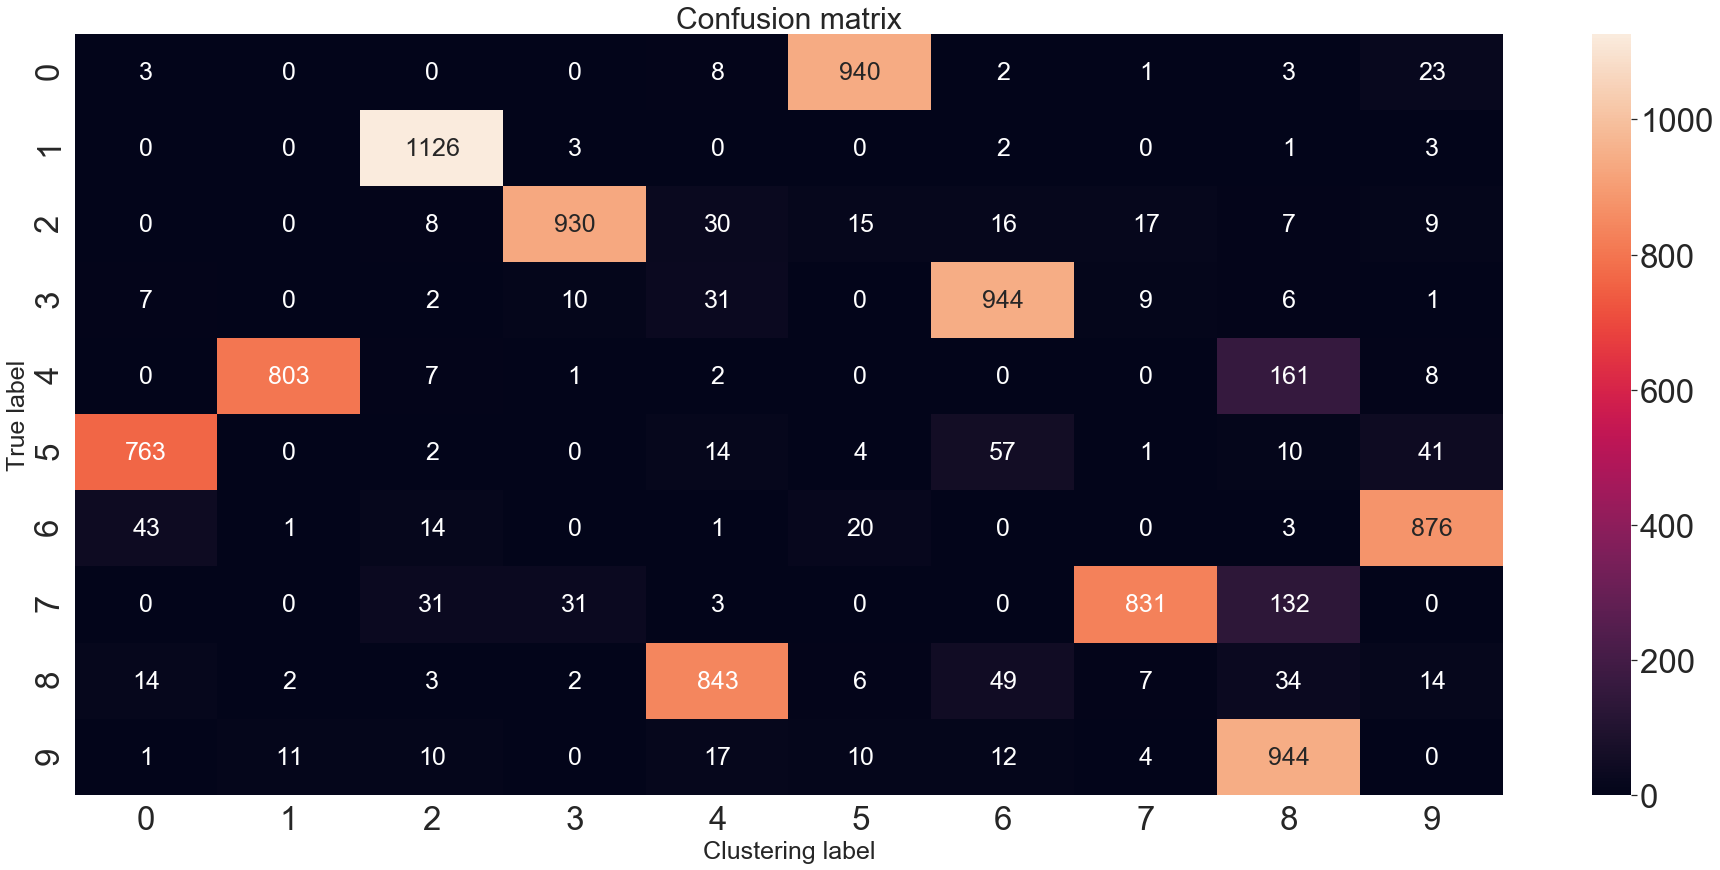

Accuracy =  90.0 % - Error =  10.0 %




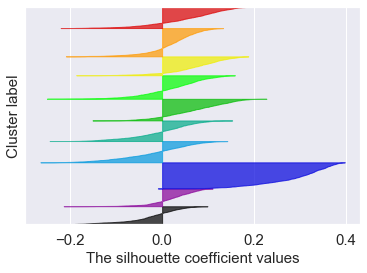


 
 
	 	 	 Results Validated with Batch  3  Dataset



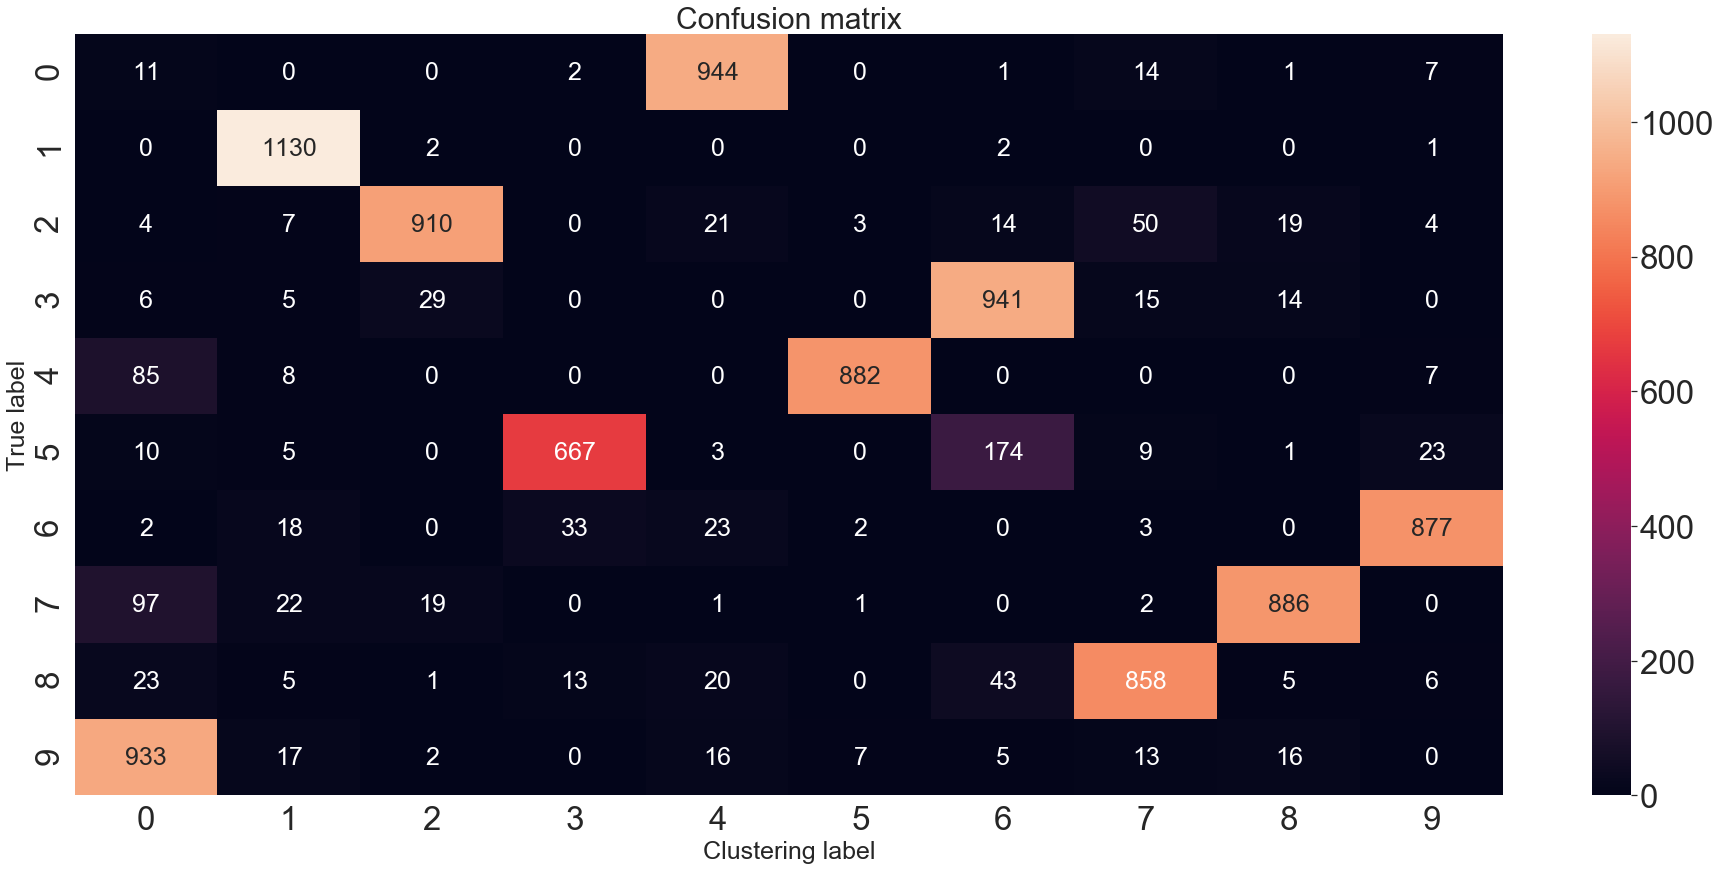

Accuracy =  90.28 % - Error =  9.719999999999999 %




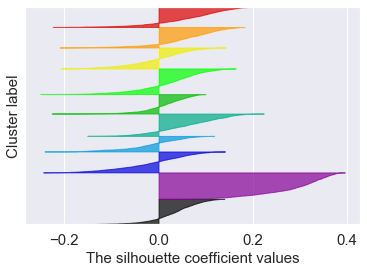


 
 
	 	 	 Results Validated with Batch  4  Dataset



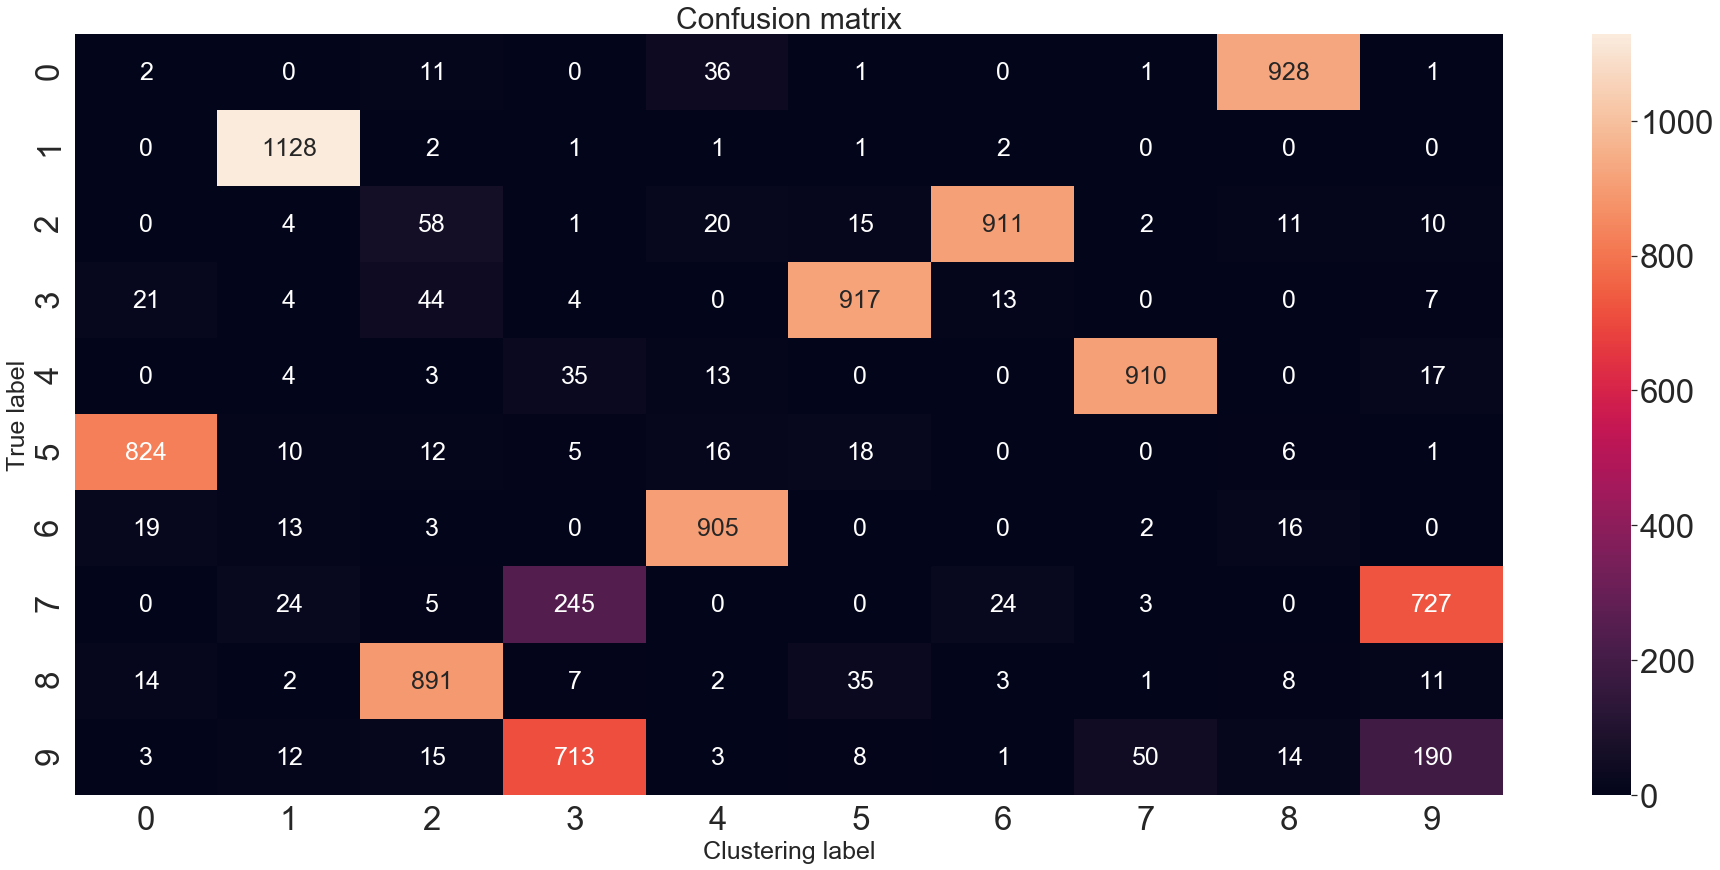

Accuracy =  88.53999999999999 % - Error =  11.459999999999999 %




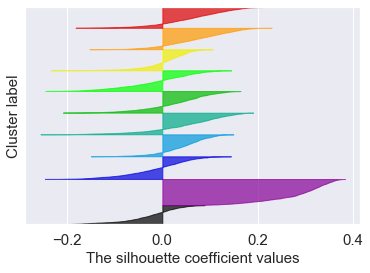


The mean accuracy, based on previous known classes, for the test dataset using cross-validation is equal to 88.24000 %, with standard deviation equal to 2.52979 %

The mean silhouette of the clusterization for the test dateset using cross-validation is equal to 0.05542, with standard deviation equal to 0.00189


In [4]:
n_clusters = 10
n_classes = 10

arq_path = 'D:\Luiza\OneDrive\Documentos\Doutorado\MeusProjetos\deep_clustering\mnist'

with open(arq_path+"\crossValidation_indexes.csv", newline='') as f:
    list_indexes = csv.reader(f)
    list_indexes = list(list(rec) for rec in csv.reader(f, delimiter=','))
list_indexes = (np.array(list_indexes)).astype(int)

test_accuracy = np.zeros((5))
test_silhouette_avg = np.zeros((5))

for i_crossVal in range(5):
    
    print('\n \n ')
    print('\t \t \t Results Validated with Batch ', i_crossVal, ' Dataset\n')
    
    i_train = np.array([w for w in range(5) if not w == i_crossVal])
    indexes_val = list_indexes[i_crossVal]
    indexes_train = np.empty(0)
    for i in range(len(i_train)):
        indexes_train = np.concatenate ((indexes_train, list_indexes[i_train[i]]), axis=0 )
    indexes_val = np.array(indexes_val)
    indexes_train = np.array(indexes_train)
    data_train, data_val, data_test, label_train, label_val, label_test = read_preprocess_dataset(arq_path, indexes_train, indexes_val ) 



    model, model_encoder = deep_clustering_model(arq_path + '\Encoder_model_'+str(i_crossVal)+'.h5', input_shape = (28,28,1))
    
    
    y_hat_train = model_encoder.predict( data_train )
    y_hat_test = model_encoder.predict( data_test )
    
    
    kmeans = KMeans(n_clusters=n_clusters,max_iter=300, n_init=10,algorithm='full', verbose=0)
    kmeans.fit(y_hat_train)  # Train K-Means.
    y_pred_kmeans = kmeans.predict(y_hat_test)  

    confusion_matrix=confusion_matrix_fn(y_pred_kmeans,np.squeeze(label_test), n_classes=n_classes, n_clusters=n_clusters )
    plot_cm(confusion_matrix, arq = arq_path +'\confusionMatrix_encodedImage_CNN_'+str(i_crossVal)+'.jpg')
    test_accuracy[i_crossVal],err = accuracy(n_clusters, confusion_matrix)
    print('Accuracy = ',test_accuracy[i_crossVal]*100,'% - Error = ',err*100, '%')
    
    
    print ('\n')
    
    test_silhouette_avg[i_crossVal] = silhouette_score(data_test.reshape((len(data_test),-1)), np.squeeze(y_pred_kmeans),metric='euclidean')
    sample_silhouette_values = silhouette_samples(data_test.reshape((len(data_test),-1)), np.squeeze(y_pred_kmeans),metric='euclidean')
    silhouette_plot(np.squeeze(y_pred_kmeans),test_silhouette_avg[i_crossVal], sample_silhouette_values, n_clusters,  arq = arq_path+'\silhouette__encodedImage_CNN_'+str(i_crossVal)+'.jpg')
    plt.show()
    
test_accuracy_mean = np.mean(test_accuracy)
test_accuracy_std = np.std(test_accuracy)

test_silhouette_avg_mean = np.mean(test_silhouette_avg)
test_silhouette_avg_std = np.std(test_silhouette_avg)

print ('\nThe mean accuracy, based on previous known classes, for the test dataset using cross-validation is equal to %.5f %%, with standard deviation equal to %.5f %%' %(test_accuracy_mean*100, test_accuracy_std*100))
print('\nThe mean silhouette of the clusterization for the test dateset using cross-validation is equal to %.5f, with standard deviation equal to %.5f' %(test_silhouette_avg_mean, test_silhouette_avg_std))

<br/><br/>
# Deep Clustering the MNIST Dataset 

<br/><br/>
Finally, a deep clustering model is trained for the MNIST dataset.<br/>
As the autoenconders were trained using 5-folds cross-validation, five deep clustering models are trained, one for each encoder. <br/>
Lastly, the models are tested with the test dataset.<br/>

Iter 0: acc = 0.88540  ; loss= 0
Iter 140: acc = 0.88540  ; loss= 0.05824
Iter 280: acc = 0.88540  ; loss= 0.09022
Iter 420: acc = 0.88540  ; loss= 0.11209
Iter 560: acc = 0.88540  ; loss= 0.13676
Iter 700: acc = 0.88540  ; loss= 0.1548
Iter 840: acc = 0.88540  ; loss= 0.15135
Iter 980: acc = 0.88540  ; loss= 0.14624
Iter 1120: acc = 0.88540  ; loss= 0.15353
Iter 1260: acc = 0.88540  ; loss= 0.14383
Iter 1400: acc = 0.88540  ; loss= 0.14498
Iter 1540: acc = 0.88540  ; loss= 0.14281
Iter 1680: acc = 0.88540  ; loss= 0.14207
Iter 1820: acc = 0.88540  ; loss= 0.12972
Iter 1960: acc = 0.88540  ; loss= 0.13919
Iter 2100: acc = 0.88540  ; loss= 0.13712
Iter 2240: acc = 0.88540  ; loss= 0.13367
Iter 2380: acc = 0.88540  ; loss= 0.12671
Iter 2520: acc = 0.88540  ; loss= 0.12503
Iter 2660: acc = 0.88540  ; loss= 0.1258
Iter 2800: acc = 0.88540  ; loss= 0.12283
Iter 2940: acc = 0.88540  ; loss= 0.13083
Iter 3080: acc = 0.88540  ; loss= 0.11776
Iter 3220: acc = 0.88540  ; loss= 0.12324
Iter 3360:

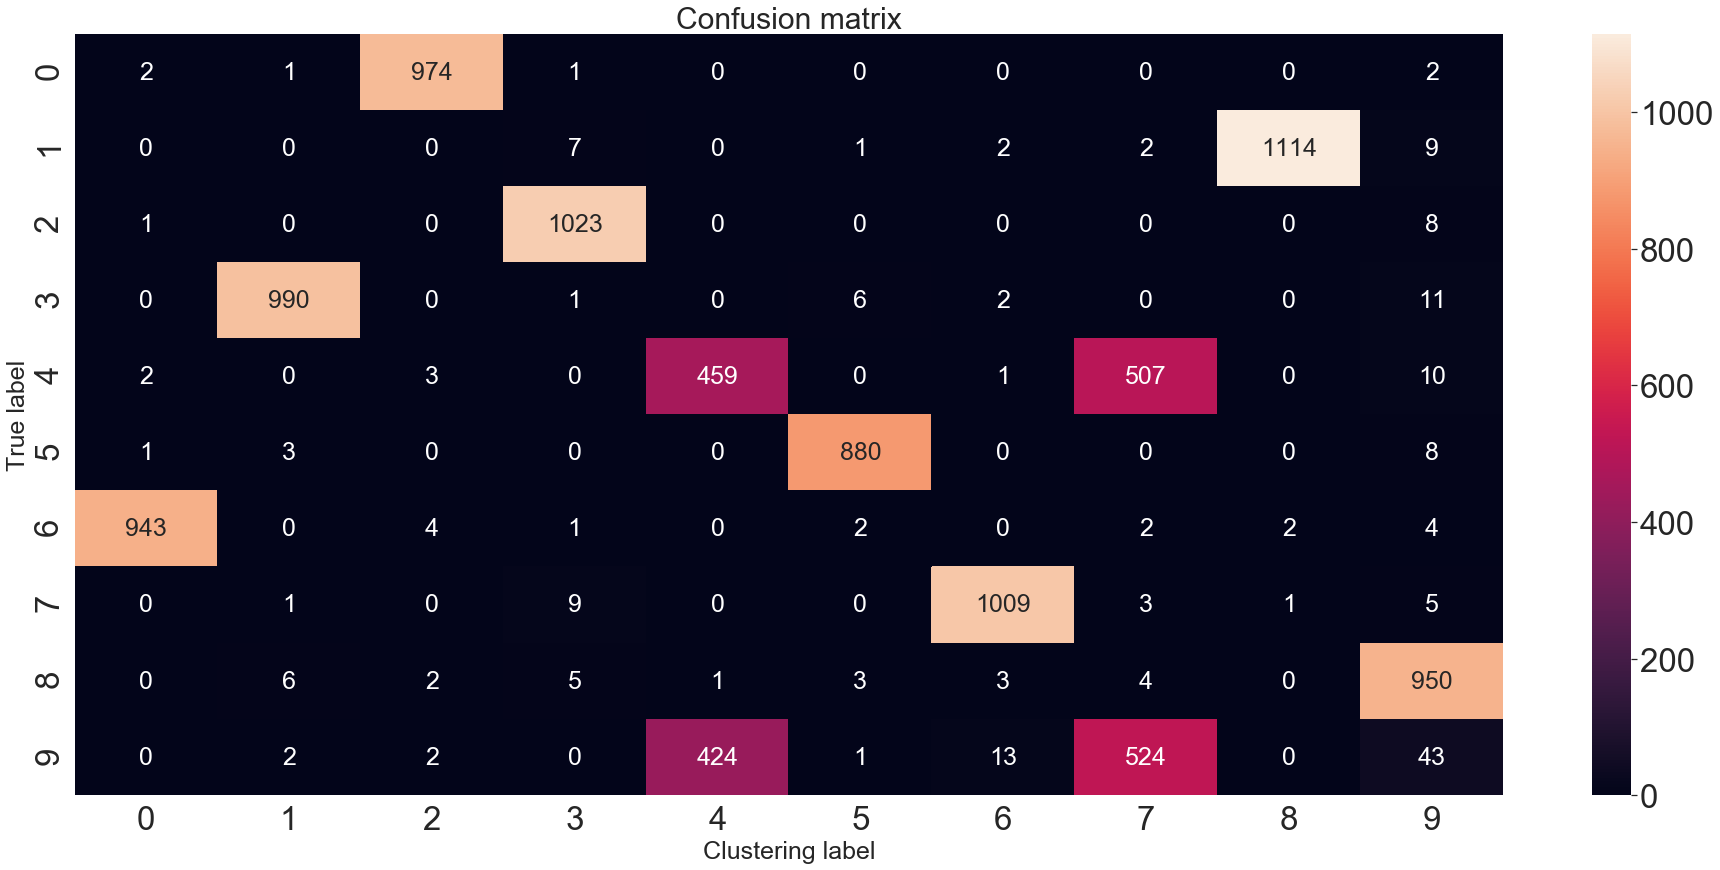

Accuracy =  88.53999999999999
Error =  11.34


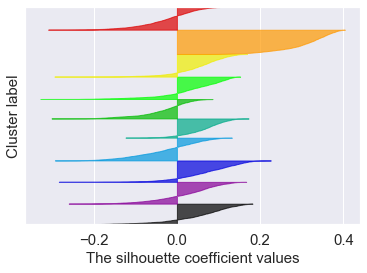

Iter 0: acc = 0.88660  ; loss= 0
Iter 140: acc = 0.88660  ; loss= 0.0557
Iter 280: acc = 0.88660  ; loss= 0.11915
Iter 420: acc = 0.88660  ; loss= 0.13245
Iter 560: acc = 0.88660  ; loss= 0.14565
Iter 700: acc = 0.88660  ; loss= 0.14492
Iter 840: acc = 0.88660  ; loss= 0.14904
Iter 980: acc = 0.88660  ; loss= 0.14582
Iter 1120: acc = 0.88660  ; loss= 0.15242
Iter 1260: acc = 0.88660  ; loss= 0.14029
Iter 1400: acc = 0.88660  ; loss= 0.13242
Iter 1540: acc = 0.88660  ; loss= 0.13118
Iter 1680: acc = 0.88660  ; loss= 0.13255
Iter 1820: acc = 0.88660  ; loss= 0.12622
Iter 1960: acc = 0.88660  ; loss= 0.12946
Iter 2100: acc = 0.88660  ; loss= 0.12797
Iter 2240: acc = 0.88660  ; loss= 0.12054
Iter 2380: acc = 0.88660  ; loss= 0.1223
Iter 2520: acc = 0.88660  ; loss= 0.11687
Iter 2660: acc = 0.88660  ; loss= 0.12339
Iter 2800: acc = 0.88660  ; loss= 0.11395
Iter 2940: acc = 0.88660  ; loss= 0.11278
Iter 3080: acc = 0.88660  ; loss= 0.11128
Iter 3220: acc = 0.88660  ; loss= 0.11072
Iter 3360:

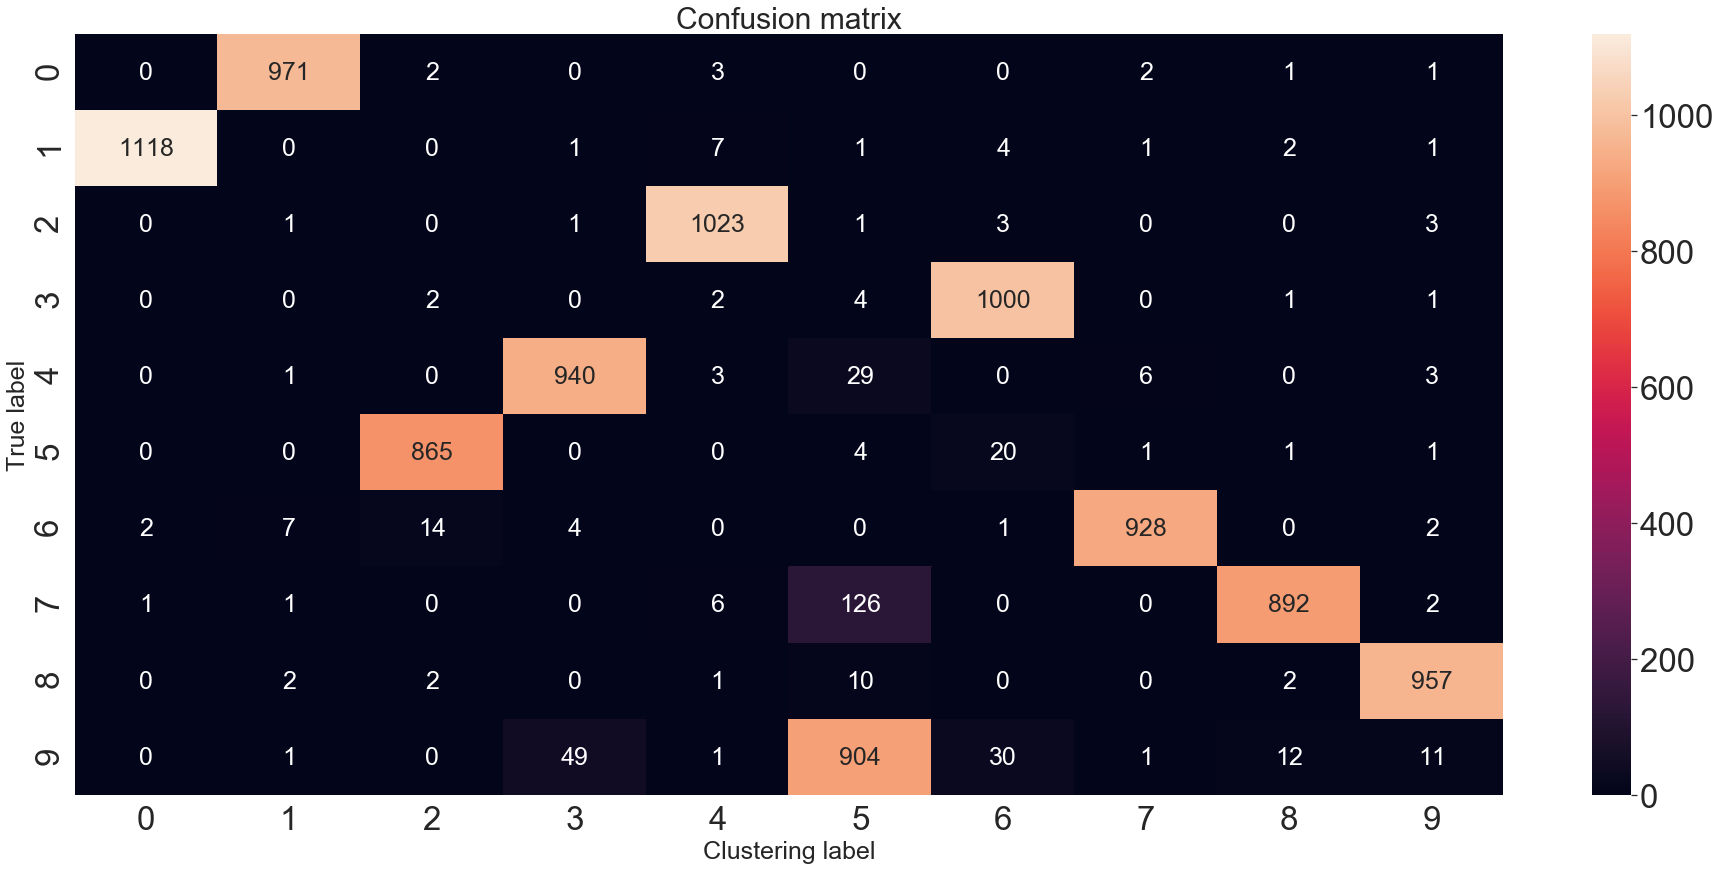

Accuracy =  88.66000000000001
Error =  4.02


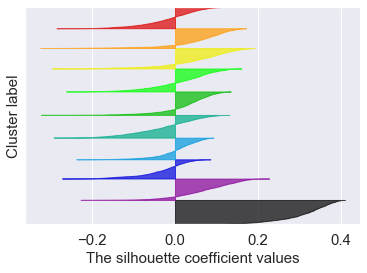

Iter 0: acc = 0.95980  ; loss= 0
Iter 140: acc = 0.95980  ; loss= 0.05262
Iter 280: acc = 0.95980  ; loss= 0.10166
Iter 420: acc = 0.95980  ; loss= 0.12282
Iter 560: acc = 0.95980  ; loss= 0.14271
Iter 700: acc = 0.95980  ; loss= 0.14589
Iter 840: acc = 0.95980  ; loss= 0.15074
Iter 980: acc = 0.95980  ; loss= 0.13912
Iter 1120: acc = 0.95980  ; loss= 0.14215
Iter 1260: acc = 0.95980  ; loss= 0.13698
Iter 1400: acc = 0.95980  ; loss= 0.13331
Iter 1540: acc = 0.95980  ; loss= 0.12527
Iter 1680: acc = 0.95980  ; loss= 0.13488
Iter 1820: acc = 0.95980  ; loss= 0.12439
Iter 1960: acc = 0.95980  ; loss= 0.13117
Iter 2100: acc = 0.95980  ; loss= 0.13183
Iter 2240: acc = 0.95980  ; loss= 0.12414
Iter 2380: acc = 0.95980  ; loss= 0.12028
Iter 2520: acc = 0.95980  ; loss= 0.1224
Iter 2660: acc = 0.95980  ; loss= 0.11912
Iter 2800: acc = 0.95980  ; loss= 0.117
Iter 2940: acc = 0.95980  ; loss= 0.11695
Iter 3080: acc = 0.95980  ; loss= 0.11373
Iter 3220: acc = 0.95980  ; loss= 0.11
Iter 3360: acc

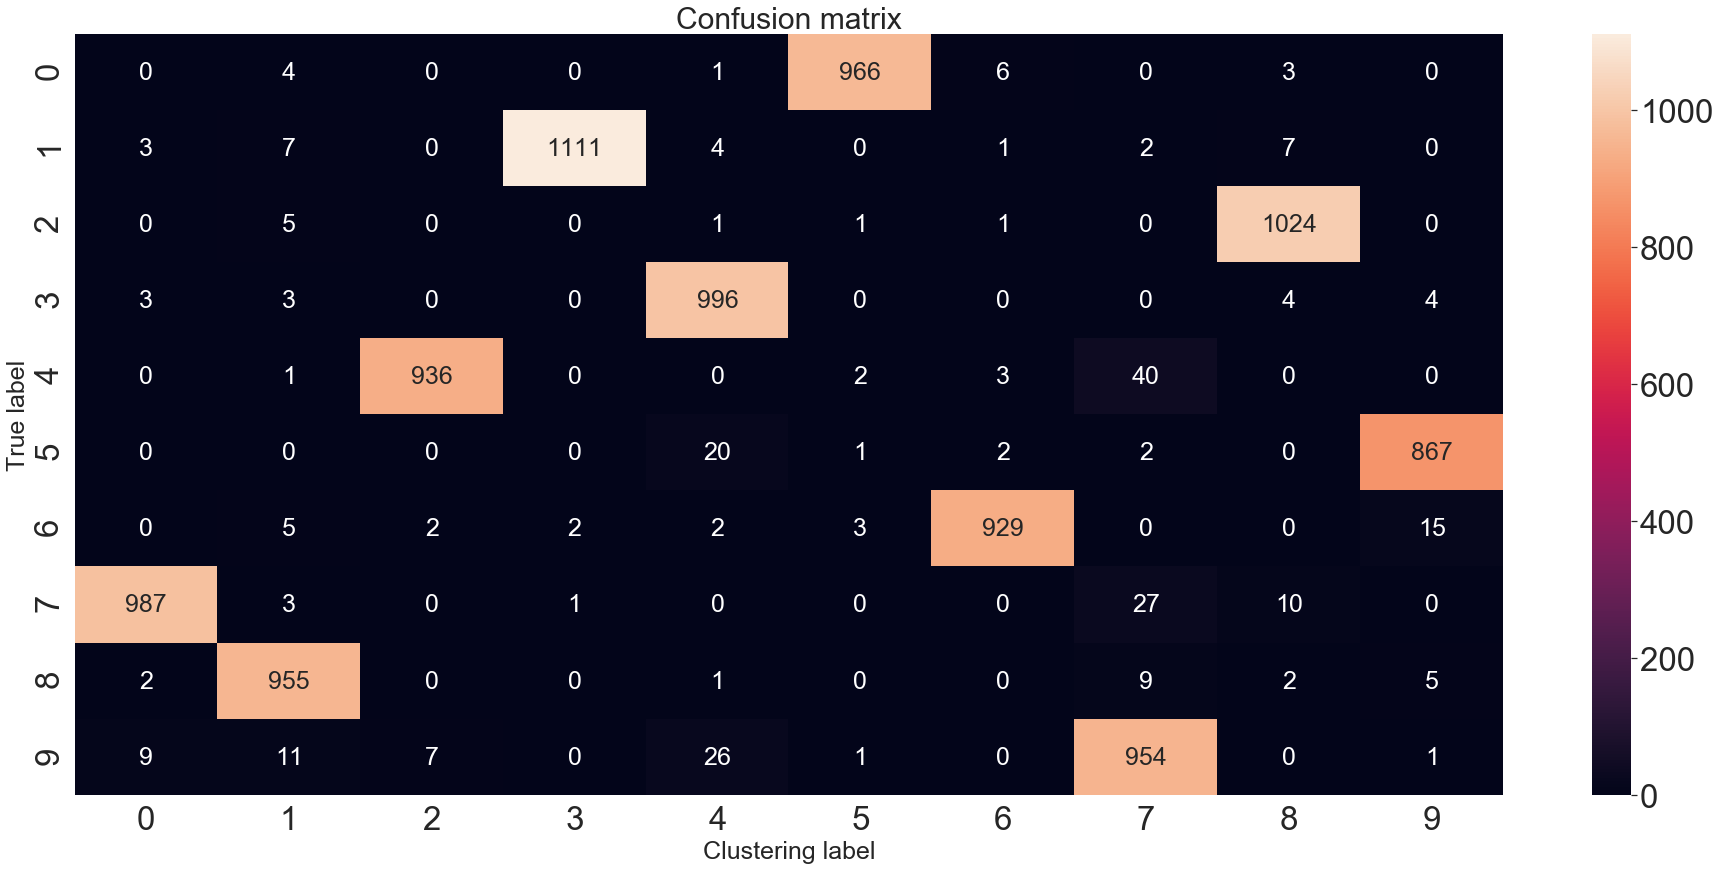

Accuracy =  95.98
Error =  2.75


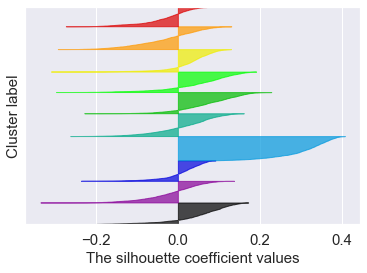

Iter 0: acc = 0.97250  ; loss= 0
Iter 140: acc = 0.97250  ; loss= 0.04917
Iter 280: acc = 0.97250  ; loss= 0.09601
Iter 420: acc = 0.97250  ; loss= 0.11533
Iter 560: acc = 0.97250  ; loss= 0.13766
Iter 700: acc = 0.97250  ; loss= 0.14972
Iter 840: acc = 0.97250  ; loss= 0.14927
Iter 980: acc = 0.97250  ; loss= 0.1391
Iter 1120: acc = 0.97250  ; loss= 0.14611
Iter 1260: acc = 0.97250  ; loss= 0.13043
Iter 1400: acc = 0.97250  ; loss= 0.13699
Iter 1540: acc = 0.97250  ; loss= 0.13106
Iter 1680: acc = 0.97250  ; loss= 0.12509
Iter 1820: acc = 0.97250  ; loss= 0.12859
Iter 1960: acc = 0.97250  ; loss= 0.13134
Iter 2100: acc = 0.97250  ; loss= 0.12814
Iter 2240: acc = 0.97250  ; loss= 0.12289
Iter 2380: acc = 0.97250  ; loss= 0.13211
Iter 2520: acc = 0.97250  ; loss= 0.11369
Iter 2660: acc = 0.97250  ; loss= 0.12393
Iter 2800: acc = 0.97250  ; loss= 0.11573
Iter 2940: acc = 0.97250  ; loss= 0.11799
Iter 3080: acc = 0.97250  ; loss= 0.10793
Iter 3220: acc = 0.97250  ; loss= 0.11454
Iter 3360

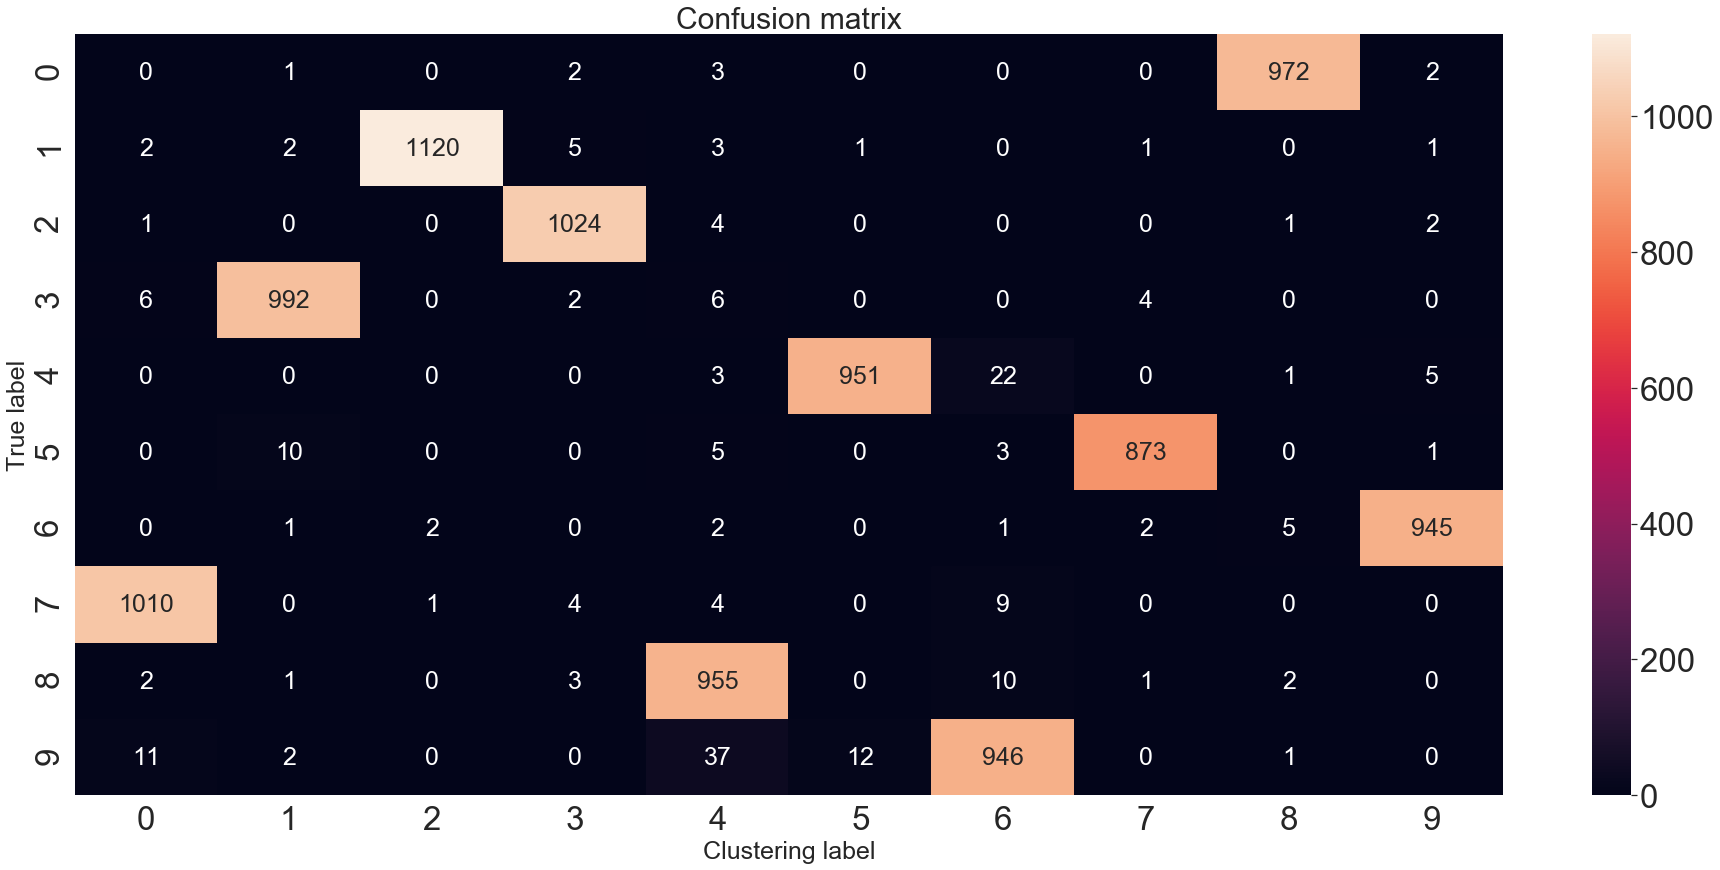

Accuracy =  97.25
Error =  2.12


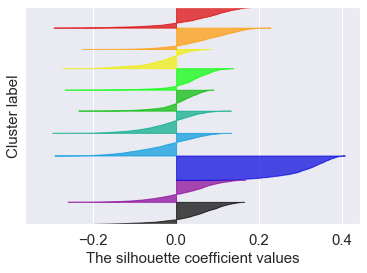

Iter 0: acc = 0.97880  ; loss= 0
Iter 140: acc = 0.97880  ; loss= 0.04721
Iter 280: acc = 0.97880  ; loss= 0.10401
Iter 420: acc = 0.97880  ; loss= 0.1061
Iter 560: acc = 0.97880  ; loss= 0.14469
Iter 700: acc = 0.97880  ; loss= 0.15147
Iter 840: acc = 0.97880  ; loss= 0.15596
Iter 980: acc = 0.97880  ; loss= 0.15002
Iter 1120: acc = 0.97880  ; loss= 0.14512
Iter 1260: acc = 0.97880  ; loss= 0.14619
Iter 1400: acc = 0.97880  ; loss= 0.14264
Iter 1540: acc = 0.97880  ; loss= 0.13741
Iter 1680: acc = 0.97880  ; loss= 0.1288
Iter 1820: acc = 0.97880  ; loss= 0.1316
Iter 1960: acc = 0.97880  ; loss= 0.14599
Iter 2100: acc = 0.97880  ; loss= 0.13393
Iter 2240: acc = 0.97880  ; loss= 0.12004
Iter 2380: acc = 0.97880  ; loss= 0.13488
Iter 2520: acc = 0.97880  ; loss= 0.12596
Iter 2660: acc = 0.97880  ; loss= 0.12443
Iter 2800: acc = 0.97880  ; loss= 0.12447
Iter 2940: acc = 0.97880  ; loss= 0.12091
Iter 3080: acc = 0.97880  ; loss= 0.12079
Iter 3220: acc = 0.97880  ; loss= 0.1163
Iter 3360: a

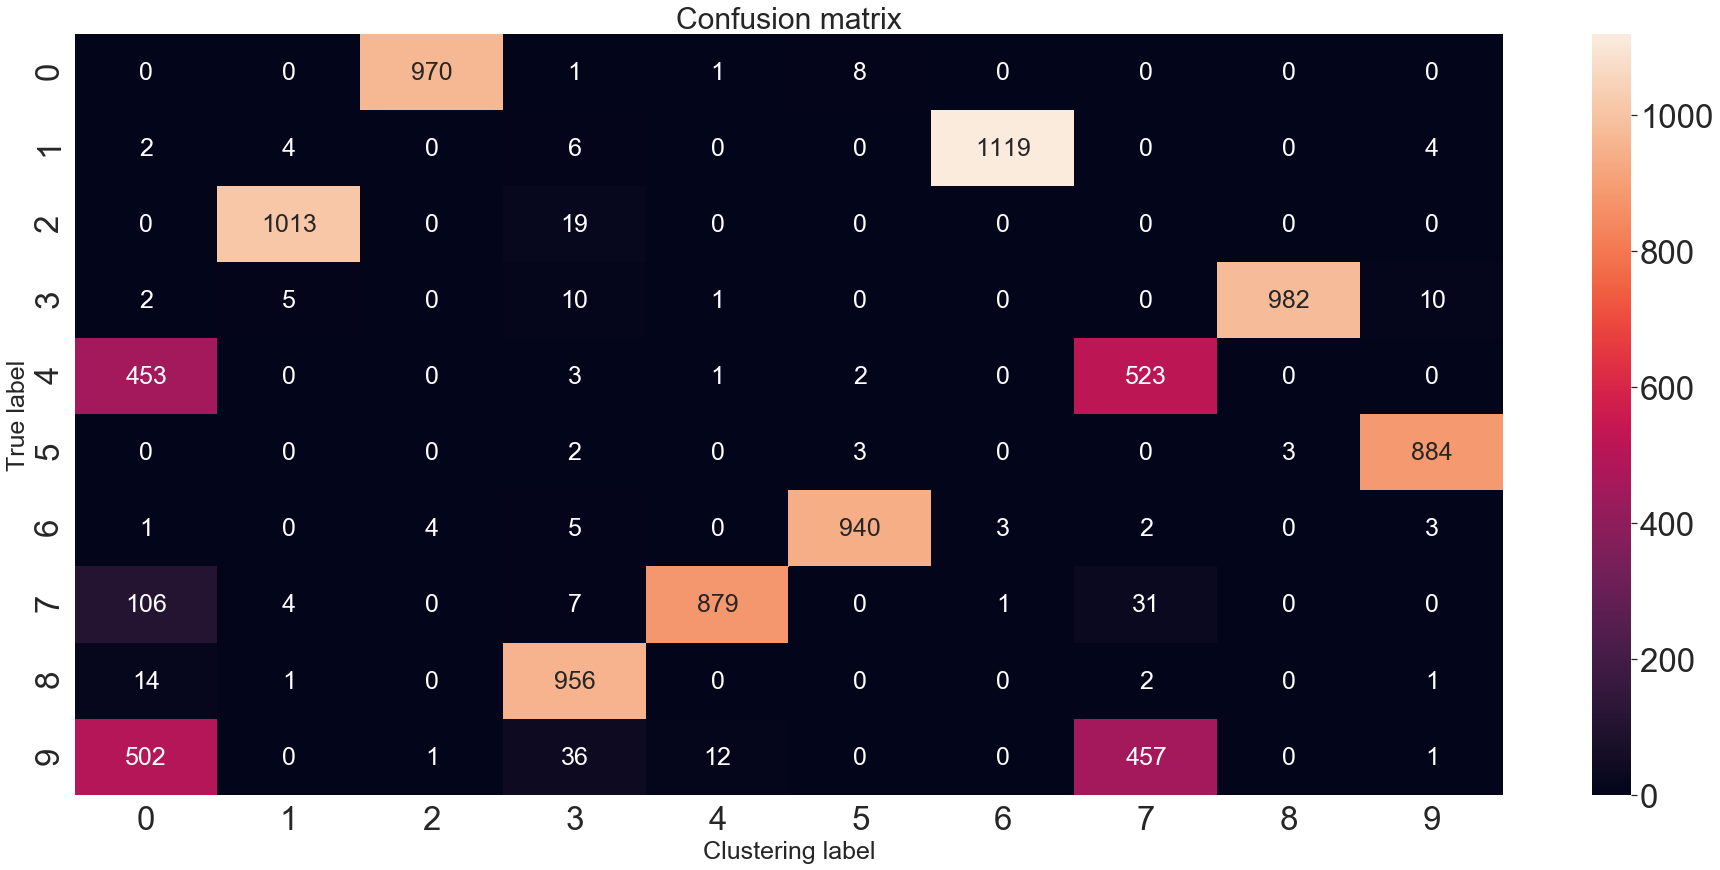

Accuracy =  97.88
Error =  12.32


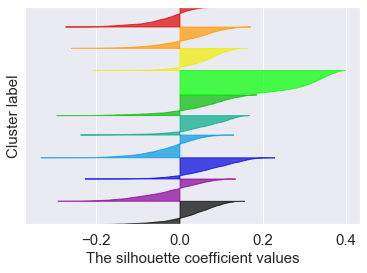


The mean accuracy, based on previous known classes, for the test dataset using cross-validation is equal to 93.49000 %, with standard deviation equal to 4.39761 %

The mean silhouette of the clusterization for the test dateset using cross-validation is equal to 0.05044, with standard deviation equal to 0.00234


In [5]:



n_clusters = 10
n_classes = 10

arq_path = 'D:\Luiza\OneDrive\Documentos\Doutorado\MeusProjetos\deep_clustering\mnist'

with open(arq_path+"\crossValidation_indexes.csv", newline='') as f:
    list_indexes = csv.reader(f)
    list_indexes = list(list(rec) for rec in csv.reader(f, delimiter=','))
list_indexes = (np.array(list_indexes)).astype(int)

test_accuracy = np.zeros((5))
test_silhouette_avg = np.zeros((5))

for i_crossVal in range(5):
    

    i_train = np.array([w for w in range(5) if not w == i_crossVal])
    indexes_val = list_indexes[i_crossVal]
    indexes_train = np.empty(0)
    for i in range(len(i_train)):
        indexes_train = np.concatenate ((indexes_train, list_indexes[i_train[i]]), axis=0 )
    indexes_val = np.array(indexes_val)
    indexes_train = np.array(indexes_train)
    data_train, data_val, data_test, label_train, label_val, label_test = read_preprocess_dataset(arq_path, indexes_train, indexes_val ) 

    
    model, model_encoder = deep_clustering_model(arq_path + '\Encoder_model_'+str(i_crossVal)+'.h5', input_shape = (28,28,1))
    
    clustering_layer = ClusteringLayer(n_clusters, name='clustering')(model_encoder.output)
    model = Model(inputs=model_encoder.input, outputs=clustering_layer)
    
    kmeans = KMeans(n_clusters=n_clusters, n_init=20)
    y_pred = kmeans.fit_predict(model_encoder.predict(data_train))


    y_pred_last = np.copy(y_pred)
    model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])
    
    model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.01, momentum=0.9), loss='kld')
    
    batch_size = 256

    loss = 0
    index = 0
    maxiter = 8000
    update_interval = 140
    index_array = np.arange(data_train.shape[0])

    tol = 0.001 # tolerance threshold to stop training


    for ite in range(int(maxiter)):
    
        
        if ite % update_interval == 0:
            q = model.predict(data_train, verbose=0)
            p = target_distribution(q)  # update the auxiliary target distribution p

            # evaluate the clustering performance
            y_pred = q.argmax(1)
            if label_train is not None:
                acc,_ = np.round(accuracy(n_clusters, confusion_matrix), 5)
                loss = np.round(loss, 5)
                print('Iter %d: acc = %.5f' % (ite, acc), ' ; loss=', loss)

            # check stop criterion - model convergence
            delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
            y_pred_last = np.copy(y_pred)
            if ite > 0 and delta_label < tol:
                print('delta_label ', delta_label, '< tol ', tol)
                print('Reached tolerance threshold. Stopping training.')
                break
        idx = index_array[index * batch_size: min((index+1) * batch_size, data_train.shape[0])]
        loss = model.train_on_batch(x=data_train[idx], y=p[idx])
        index = index + 1 if (index + 1) * batch_size <= data_train.shape[0] else 0

    model.save(arq_path + '\Keras_Deep_Clustering_model_'+str(i_crossVal)+'.h5')





    # evaluate the clustering performance
    q = model.predict(data_test, verbose=0)
    y_pred = q.argmax(1)
    # Evaluate the K-Means clustering accuracy.
    confusion_matrix = confusion_matrix_fn(y_pred,np.squeeze(label_test), n_classes=n_classes, n_clusters=n_clusters)
    test_accuracy[i_crossVal],error = accuracy(n_clusters, confusion_matrix)
    plot_cm(confusion_matrix, arq=arq_path+'\confusioMatrix_KerasDeepClusteringModel_'+str(i_crossVal)+'.jpg')
    plt.show()

    print('Accuracy = ',acc*100)
    print('Error = ', error*100)

    test_silhouette_avg[i_crossVal] = silhouette_score(data_test.reshape((len(data_test),-1)), np.squeeze(y_pred),metric='euclidean')
    sample_silhouette_values = silhouette_samples(data_test.reshape((len(data_test),-1)), np.squeeze(y_pred),metric='euclidean')
    silhouette_plot(np.squeeze(y_pred),test_silhouette_avg[i_crossVal], sample_silhouette_values, n_clusters, arq=arq_path+'\silhouette_KerasDeepClusteringModel_'+str(i_crossVal)+'.jpg')
    plt.show()
    
test_accuracy_mean = np.mean(test_accuracy)
test_accuracy_std = np.std(test_accuracy)

test_silhouette_avg_mean = np.mean(test_silhouette_avg)
test_silhouette_avg_std = np.std(test_silhouette_avg)
    
print ('\nThe mean accuracy, based on previous known classes, for the test dataset using cross-validation is equal to %.5f %%, with standard deviation equal to %.5f %%' %(test_accuracy_mean*100, test_accuracy_std*100))
print('\nThe mean silhouette of the clusterization for the test dateset using cross-validation is equal to %.5f, with standard deviation equal to %.5f' %(test_silhouette_avg_mean, test_silhouette_avg_std))

<br/>

### Deep Clustering Models Results

In [6]:
print ('\nThe mean accuracy, based on previous known classes, for the test dataset using cross-validation is equal to %.5f %%, with standard deviation equal to %.5f %%' %(test_accuracy_mean*100, test_accuracy_std*100))
print('\nThe mean silhouette of the clusterization for the test dateset using cross-validation is equal to %.5f, with standard deviation equal to %.5f' %(test_silhouette_avg_mean, test_silhouette_avg_std))


The mean accuracy, based on previous known classes, for the test dataset using cross-validation is equal to 93.49000 %, with standard deviation equal to 4.39761 %

The mean silhouette of the clusterization for the test dateset using cross-validation is equal to 0.05044, with standard deviation equal to 0.00234
